#**Transformers: Bert**

In [6]:
import os
import platform
# Operating System
OS = platform.system()                                                               # returns 'Windows', 'Linux', etc

if not os.path.exists("./sentiment_data.zip"):
    os.system('gdown --id "13XYWLVV4YccljoZ1ic-vXymr8OGK7r6B" --output "./sentiment_data.zip"')
    if OS == "Linux":
        os.system('unzip -o -n "./sentiment_data.zip" -d "./"')

if not os.path.exists("./test_sets.zip"):
    os.system('gdown --id "1kIsaAilRAo9bHv2tgX_CQqDM0pRM9A4o" --output "./test_sets.zip"')
    if OS == "Linux":
        os.system('unzip -o -n "./test_sets.zip" -d "./"')

In [7]:
os.system('pip install transformers=="3.0.0"')

0

In [8]:
import csv
import pdb
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import torch
import pandas as pd
from torch import nn  
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

In [9]:
gpu = torch.cuda.is_available()
print("GPU Available: ", gpu)
limit = None
sentipolc = False
all_encoded_classes = ['-1','0','1']
all_classes = ["Negative", "Neutral", "Positive"]
test_sentences = ["Questa è una brutta cosa", "Questa non è una brutta cosa", "Questa è una cosa positiva", "Questa è una cosa molto positiva", "Mi piace la politica di tizio", "Non condivido la politica di tizio", "Tizio ha fatto una cattiva politica internazionale", "Tizio ha fatto una politica internazionale molto buona", "Tizio non ha fatto una cattiva politica"]

GPU Available:  True


In [10]:
# Load the tokenizer
tokenizer = AutoTokenizer.from_pretrained("neuraly/bert-base-italian-cased-sentiment")
# Load the model, use .cuda() to load it on the GPU
if gpu is True: 
  model = AutoModelForSequenceClassification.from_pretrained("neuraly/bert-base-italian-cased-sentiment").cuda()
else: 
  model = AutoModelForSequenceClassification.from_pretrained("neuraly/bert-base-italian-cased-sentiment")

def bert_inference(sentence, model):
  input_ids = tokenizer.encode(sentence, add_special_tokens=True)

  # Create tensor, use .cuda() to transfer the tensor to GPU
  if gpu is True: 
    tensor = torch.tensor(input_ids).long().cuda()
  else:
    tensor = torch.tensor(input_ids).long()

  # Fake batch dimension
  tensor = tensor.unsqueeze(0)

  # Call the model and get the logits
  logits, = model(tensor)

  # Remove the fake batch dimension
  logits = logits.squeeze(0)

  # The model was trained with a Log Likelyhood + Softmax combined loss, hence to extract probabilities we need a softmax on top of the logits tensor
  proba = nn.functional.softmax(logits, dim=0)

  # Unpack the tensor to obtain negative, neutral and positive probabilities
  negative, neutral, positive = proba

  negative = np.round(float(negative), 3)
  neutral = np.round(float(neutral), 3)
  positive = np.round(float(positive), 3)

  classification = np.argmax([negative, neutral, positive])

  return negative, neutral, positive, classification

In [11]:
if sentipolc is not True: 
  file = open('./test_sets/validate_economy_set.csv', 'r', encoding='latin-1')
  file_out = open('./validate_economy_set_with_bert.csv', 'w+', newline ='')
else: 
  file = open('./test_sets/sentipolc_con_sentiment.csv', 'r', encoding='latin-1')
  file_out = open('./sentipolc_con_sentiment_bert.csv', 'w+', newline ='')

i = 0
data_set_smei = []
gt_sentiment_data_pnn = []
gt_sentiment_data_pn = []
bert_sentiment_data = []
bert_sentiment_data_pn = []
for line in file:
    i=i+1 
    if sentipolc is not True: 
      splittedline = line.split(sep = ';')                                                          
    else:
      if i>1: 
        splittedline = line.split(sep = '"')                                                          
   
    if limit is not None and i>=limit:                         # reads only few rows
        break
    
    if sentipolc is not True: 
      sentence = splittedline[6]
      sentiment_pos_neutro_neg = splittedline[10]
      sentiment_solo_pos_o_neg = splittedline[11]
      #print("\n\n"+splittedline[11]+"\n\n")

      [v3, data_tweet, m_score_positivo, m_score_negativo, n_parole, n_parole_score, testo, m_score_neutro, dpl_sentiment_argmax, score_pos_score_neg, elena_sentiment_pos_netro_neg, sentiment_solo_pos_o_neg, id_stringa] = splittedline
    else:
      if i>1:
        sentence = splittedline[3]
        sentiment_pos_neutro_neg = splittedline[-1].split()[-1]

    if i == 1: 
      bert_negative = 'bert_negative'
      bert_neutral = 'bert_neutral'
      bert_positive = 'bert_positive'
      bert_classification = 'bert_classification'
      bert_sentiment = 'bert_sentiment_pos_neutral_neg'
      bert_sentiment_pn = 'bert_sentiment_pos_neg'
    else: 
      bert_negative, bert_neutral, bert_positive, classification = bert_inference(sentence, model)
      bert_sentiment = all_encoded_classes[classification]
      bert_classification = all_classes[classification]
      if bert_positive - bert_negative > 0:
        bert_sentiment_pn = 1
      else: 
        bert_sentiment_pn = -1
    
    if sentiment_pos_neutro_neg != 'NA':
      print("\nSentence: ", sentence)
      print("Bert: ")
      print("Sentiment: ", bert_sentiment)
      print("Class: ", bert_classification)
      print("Negative Probability: ", bert_negative)
      print("Neutral Probability: ", bert_neutral)
      print("Positive Probability: ", bert_positive)
      print("Bert Sentiment PN: ", bert_sentiment_pn)

      print("Ground Truth: ")
      if sentipolc is not True: 
        print("Sentiment (Positive or Negative): ", sentiment_solo_pos_o_neg)
        print("Sentiment (Positive, Neutral or Negative): ", sentiment_pos_neutro_neg)
      else:
        print("Sentiment (Positive, Neutral or Negative): ", sentiment)

      if sentipolc is not True: 
        data_set_smei.append([v3, data_tweet, m_score_positivo, m_score_negativo, n_parole, n_parole_score, testo, m_score_neutro, dpl_sentiment_argmax, score_pos_score_neg, elena_sentiment_pos_netro_neg, sentiment_solo_pos_o_neg, id_stringa, bert_sentiment, bert_sentiment_pn])
      else: 
        data_set_smei.append([line, bert_sentiment_pn, bert_sentiment])

      if i>1:
        if sentipolc is not True:   
          gt_sentiment_data_pnn.append(int(sentiment_pos_neutro_neg))
          gt_sentiment_data_pn.append(int(sentiment_solo_pos_o_neg))
          bert_sentiment_data.append(int(bert_sentiment))
          bert_sentiment_data_pn.append(int(bert_sentiment_pn))
        else: 
          gt_sentiment_data_pnn.append(int(sentiment_pos_neutro_neg))
          bert_sentiment_data.append(int(bert_sentiment))
          if sentiment_pos_neutro_neg != '0':
            gt_sentiment_data_pn.append(int(sentiment_pos_neutro_neg))
            bert_sentiment_data_pn.append(int(bert_sentiment_pn))

if sentipolc is not True:   
  delim = ';'
else:
  delim = ' '

with file_out:	
	write = csv.writer(file_out, delimiter = delim)
	write.writerows(data_set_smei)

gt_sentiment_data_pnn_count = [gt_sentiment_data_pnn.count(-1), gt_sentiment_data_pnn.count(0), gt_sentiment_data_pnn.count(1)]
gt_sentiment_data_pn_count = [gt_sentiment_data_pn.count(-1), gt_sentiment_data_pn.count(0), gt_sentiment_data_pn.count(1)]
bert_sentiment_data_count = [bert_sentiment_data.count(-1), bert_sentiment_data.count(0), bert_sentiment_data.count(1)]
bert_sentiment_data_pn_count = [bert_sentiment_data_pn.count(-1), bert_sentiment_data_pn.count(0), bert_sentiment_data_pn.count(1)]
print(gt_sentiment_data_pnn_count)
print(gt_sentiment_data_pn_count)
print(bert_sentiment_data_count)
print(bert_sentiment_data_pn_count)


Sentence:  testo
Bert: 
Sentiment:  bert_sentiment_pos_neutral_neg
Class:  bert_classification
Negative Probability:  bert_negative
Neutral Probability:  bert_neutral
Positive Probability:  bert_positive
Bert Sentiment PN:  bert_sentiment_pos_neg
Ground Truth: 
Sentiment (Positive or Negative):  sentiment (solo pos o neg)
Sentiment (Positive, Neutral or Negative):  elena_sentiment(pos_netro_neg)

Sentence:  briatore le banche non danno un euro a chi ? in difficolt? sar? una catastrofe conte non ha detto una parola sul turismo purtroppo lo sappiamo nonelarena
Bert: 
Sentiment:  0
Class:  Neutral
Negative Probability:  0.194
Neutral Probability:  0.802
Positive Probability:  0.004
Bert Sentiment PN:  -1
Ground Truth: 
Sentiment (Positive or Negative):  -1
Sentiment (Positive, Neutral or Negative):  -1

Sentence:  accendo la televisione e c ? friedman con gli occhi fuori dalle orbite e dice di usare il mes e che il debito non ? pi? un problema perch? prima l italia aveva e spaventava ade

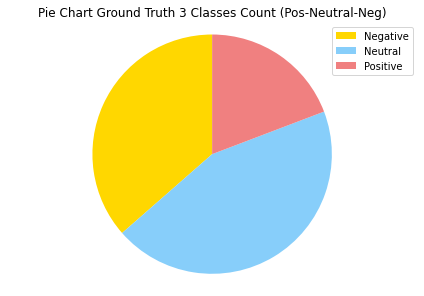

In [12]:
colors = ['gold', 'lightskyblue', 'lightcoral']
#a4_dims = (11.7, 8.27)
#fig, ax = plt.subplots(figsize=a4_dims)
patches, texts = plt.pie(gt_sentiment_data_pnn_count, colors=colors, startangle=90)
plt.legend(patches, all_classes, loc = "best")
plt.axis('equal')
plt.tight_layout()
plt.title("Pie Chart Ground Truth 3 Classes Count (Pos-Neutral-Neg)")
plt.savefig("./gt_sentiment_data_3_classes_count.jpg", bbox_inches='tight')
plt.show()

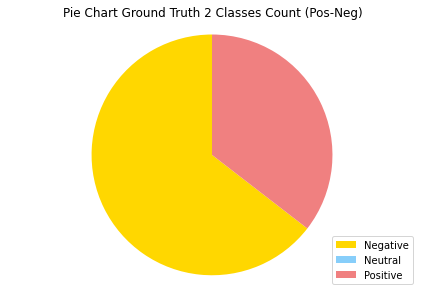

In [13]:
colors = ['gold', 'lightskyblue', 'lightcoral']
patches, texts = plt.pie(gt_sentiment_data_pn_count, colors=colors, startangle=90)
plt.legend(patches, all_classes, loc = "best")
plt.axis('equal')
plt.tight_layout()
plt.title("Pie Chart Ground Truth 2 Classes Count (Pos-Neg)")
plt.savefig("./gt_sentiment_data_2_classes_count.jpg", bbox_inches='tight')
plt.show()

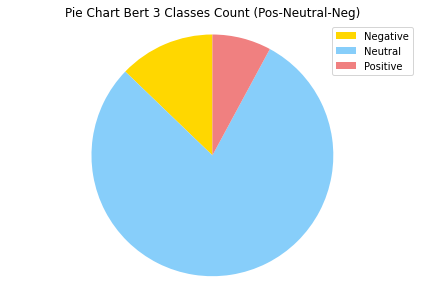

In [14]:
colors = ['gold', 'lightskyblue', 'lightcoral']
patches, texts = plt.pie(bert_sentiment_data_count, colors=colors, startangle=90)
plt.legend(patches, all_classes, loc = "best")
plt.axis('equal')
plt.tight_layout()
plt.title("Pie Chart Bert 3 Classes Count (Pos-Neutral-Neg)")
plt.savefig("./bert_sentiment_data_3_classes_count.jpg", bbox_inches='tight')
plt.show()

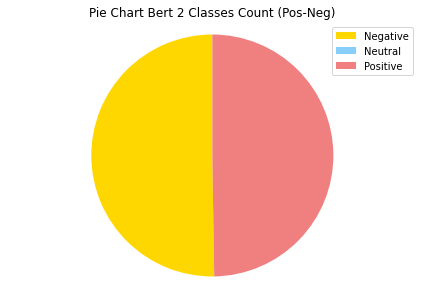

In [15]:
colors = ['gold', 'lightskyblue', 'lightcoral']
patches, texts = plt.pie(bert_sentiment_data_pn_count, colors=colors, startangle=90)
plt.legend(patches, all_classes, loc = "best")
plt.axis('equal')
plt.tight_layout()
plt.title("Pie Chart Bert 2 Classes Count (Pos-Neg)")
plt.savefig("./bert_sentiment_data_2_classes_count.jpg", bbox_inches='tight')
plt.show()

[[18 53  3]
 [ 8 76  6]
 [ 0 32  7]]
Accuracy:  0.4975369458128079
F1 Score - Micro (Accuracy):  0.49753694581280794
F1 Score - Macro:  0.40670771459616084
F1 Score - Weighted:  0.44861706777904053


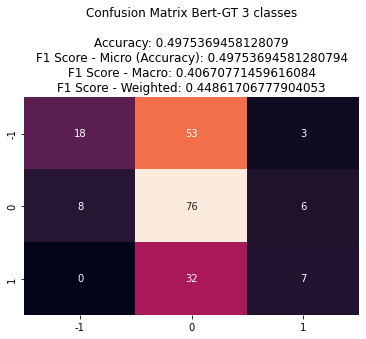

In [16]:
y = gt_sentiment_data_pnn
y_pred = bert_sentiment_data
cf_matrix = confusion_matrix(y, y_pred)
print(cf_matrix)
axis_labels = [-1,0,1] 
p = sns.heatmap(cf_matrix, annot=True, xticklabels=axis_labels, yticklabels=axis_labels, cbar = False)
p.set_title("Confusion Matrix Bert-GT 3 classes\n\n"+"Accuracy: "+str(accuracy_score(y, y_pred))+"\nF1 Score - Micro (Accuracy): "+str(f1_score(y, y_pred, average='micro'))+"\nF1 Score - Macro: "+str(f1_score(y, y_pred, average='macro'))+"\nF1 Score - Weighted: "+str(f1_score(y, y_pred, average='weighted')))
plt.savefig('confusion_matrix_bert_elenagt_pos_neutral_neg.jpg', dpi=400, bbox_inches='tight')
print("Accuracy: ", accuracy_score(y, y_pred))
print("F1 Score - Micro (Accuracy): ", f1_score(y, y_pred, average='micro'))
print("F1 Score - Macro: ", f1_score(y, y_pred, average='macro'))
print("F1 Score - Weighted: ", f1_score(y, y_pred, average='weighted'))

[[88 43]
 [14 58]]
Accuracy:  0.7192118226600985
F1 Score - Binary:  0.6705202312138728
F1 Score - Micro (Accuracy):  0.7192118226600985
F1 Score - Macro:  0.7129425190404128
F1 Score - Weighted:  0.7252721494924614


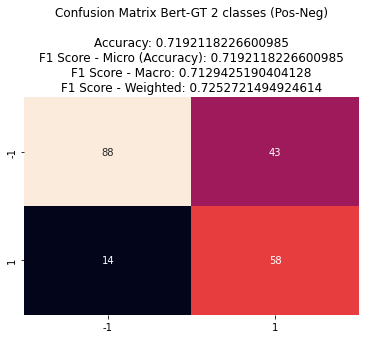

In [17]:
y = gt_sentiment_data_pn
y_pred = bert_sentiment_data_pn
cf_matrix = confusion_matrix(y, y_pred)
print(cf_matrix)
axis_labels = [-1,1] 
p = sns.heatmap(cf_matrix, annot=True, xticklabels=axis_labels, yticklabels=axis_labels, cbar = False)
p.set_title("Confusion Matrix Bert-GT 2 classes (Pos-Neg)\n\n"+"Accuracy: "+str(accuracy_score(y, y_pred))+"\nF1 Score - Micro (Accuracy): "+str(f1_score(y, y_pred, average='micro'))+"\nF1 Score - Macro: "+str(f1_score(y, y_pred, average='macro'))+"\nF1 Score - Weighted: "+str(f1_score(y, y_pred, average='weighted')))
plt.savefig('confusion_matrix_bert_elenagt_binary_pos_neg.jpg', dpi = 400, bbox_inches='tight')
print("Accuracy: ", accuracy_score(y, y_pred))
print("F1 Score - Binary: ", f1_score(y, y_pred, average='binary'))
print("F1 Score - Micro (Accuracy): ", f1_score(y, y_pred, average='micro'))
print("F1 Score - Macro: ", f1_score(y, y_pred, average='macro'))
print("F1 Score - Weighted: ", f1_score(y, y_pred, average='weighted'))

In [18]:
for sentence in test_sentences:
  negative, neutral, positive, classification = bert_inference(sentence, model)

  print("\nSentence: ", sentence)
  print("Class: ", all_classes[classification])
  print("Negative Probability: ", negative)
  print("Neutral Probability: ", neutral)
  print("Positive Probability: ", positive)


Sentence:  Questa è una brutta cosa
Class:  Negative
Negative Probability:  0.995
Neutral Probability:  0.005
Positive Probability:  0.0

Sentence:  Questa non è una brutta cosa
Class:  Positive
Negative Probability:  0.041
Neutral Probability:  0.018
Positive Probability:  0.94

Sentence:  Questa è una cosa positiva
Class:  Positive
Negative Probability:  0.0
Neutral Probability:  0.002
Positive Probability:  0.998

Sentence:  Questa è una cosa molto positiva
Class:  Positive
Negative Probability:  0.0
Neutral Probability:  0.001
Positive Probability:  0.999

Sentence:  Mi piace la politica di tizio
Class:  Neutral
Negative Probability:  0.074
Neutral Probability:  0.617
Positive Probability:  0.309

Sentence:  Non condivido la politica di tizio
Class:  Neutral
Negative Probability:  0.432
Neutral Probability:  0.566
Positive Probability:  0.002

Sentence:  Tizio ha fatto una cattiva politica internazionale
Class:  Negative
Negative Probability:  0.933
Neutral Probability:  0.066
Pos

In [19]:
file = open('./2020-04-05.csv', 'r', encoding='latin-1')
file_out = open('./2020-04-05_with_bert.csv', 'w+', newline ='')

i = 0
data_set_smei = []
smei_sentiment_data = []
bert_sentiment_data = []
for line in file:
    i=i+1 
    splittedline = line.split(sep = ';')                                                          
    if limit is not None and i>=limit:                         # reads only few rows
        break
    sentiment = splittedline[9]
    [id_tweet, data_tweet, m_score_positivo, m_score_negativo, n_parole, n_parole_score, polarity, intensity, sentence, sentiment] = splittedline

    if i == 1: 
      bert_negative = 'bert_negative'
      bert_neutral = 'bert_neutral'
      bert_positive = 'bert_positive'
      bert_classification = 'bert_classification'
      bert_sentiment = 'bert_sentiment'
    else: 
      bert_negative, bert_neutral, bert_positive, classification = bert_inference(sentence, model)
      bert_sentiment = all_encoded_classes[classification]
      bert_classification = all_classes[classification]
    
    print("\nSentence: ", sentence)
    print("Bert: ")
    print("Sentiment: ", bert_sentiment)
    print("Class: ", bert_classification)
    print("Negative Probability: ", bert_negative)
    print("Neutral Probability: ", bert_neutral)
    print("Positive Probability: ", bert_positive)
    print("SMEI: ")
    print("Sentiment: ", sentiment, end = '')
    print("Positive Score: ", m_score_positivo)
    print("Negative Score: ", m_score_negativo)
    print("Polarity: ", polarity)
    print("Intensity: ", intensity)
    
    data_set_smei.append([id_tweet, data_tweet, m_score_positivo, m_score_negativo, n_parole, n_parole_score, polarity, intensity, sentence, sentiment, bert_sentiment, bert_classification, bert_negative, bert_neutral, bert_positive])
    if i>1:
      smei_sentiment_data.append(int(sentiment))
      bert_sentiment_data.append(int(bert_sentiment))


with file_out:	
	write = csv.writer(file_out, delimiter = ';')
	write.writerows(data_set_smei)
 
smei_sentiment_data_count = [smei_sentiment_data.count(-1), smei_sentiment_data.count(0), smei_sentiment_data.count(1)]
bert_sentiment_data_count = [bert_sentiment_data.count(-1), bert_sentiment_data.count(0), bert_sentiment_data.count(1)]
print(smei_sentiment_data_count)
print(bert_sentiment_data_count)

Output streaming troncato alle ultime 5000 righe.

Sentence:  ricordiamo chi sono quelli che ora vogliono metterci il cappio maggio juncker i tedeschi hanno violato il patto di stabilità volte [] 
Bert: 
Sentiment:  0
Class:  Neutral
Negative Probability:  0.001
Neutral Probability:  0.999
Positive Probability:  0.001
SMEI: 
Sentiment:  0
Positive Score:  0.203125
Negative Score:  0.1234375
Polarity:  0.304739373487834
Intensity:  0.237690096620053

Sentence:  gitro minutemanitaly negli anni un contadino che raccoglieva pomodori a cassette al giorno guadagnava come un direttore di banca anche [] e non solo a luglio agosto a settembre x la vendemmia ad ott nov dic x le olive oggi con gli immigrati di ginostrada a h no
Bert: 
Sentiment:  0
Class:  Neutral
Negative Probability:  0.001
Neutral Probability:  0.998
Positive Probability:  0.001
SMEI: 
Sentiment:  -1
Positive Score:  0.1271875
Negative Score:  0.156145833333333
Polarity:  -0.129682266653194
Intensity:  0.201390619005978

Sente

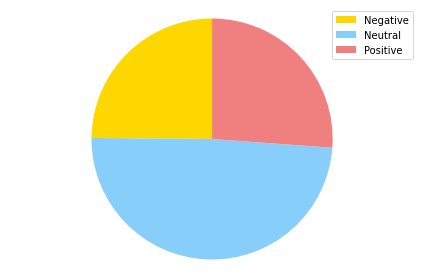

In [20]:
colors = ['gold', 'lightskyblue', 'lightcoral']
patches, texts = plt.pie(smei_sentiment_data_count, colors=colors, startangle=90)
plt.legend(patches, all_classes, loc = "best")
plt.axis('equal')
plt.tight_layout()
plt.savefig("./smei_sentiment_data_count.jpg")
plt.show()

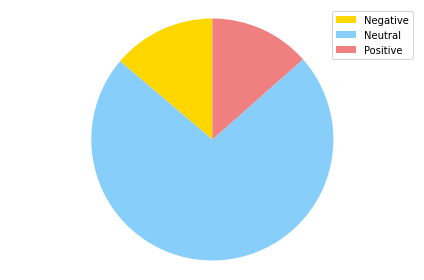

In [21]:
colors = ['gold', 'lightskyblue', 'lightcoral']
patches, texts = plt.pie(bert_sentiment_data_count, colors=colors, startangle=90)
plt.legend(patches, all_classes, loc = "best")
plt.axis('equal')
plt.tight_layout()
plt.savefig("./bert_sentiment_data_count.jpg")
plt.show()

Correlation Coefficient:  [[1.         0.19430231]
 [0.19430231 1.        ]]


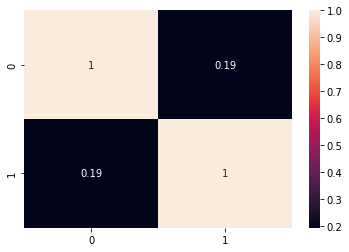

In [22]:
corr_c = np.corrcoef(smei_sentiment_data, bert_sentiment_data)
print("Correlation Coefficient: ", corr_c)
  
#ploting the heatmap for correlation
ax = sns.heatmap(corr_c, annot=True)
plt.savefig('correlation_matrix.jpg')

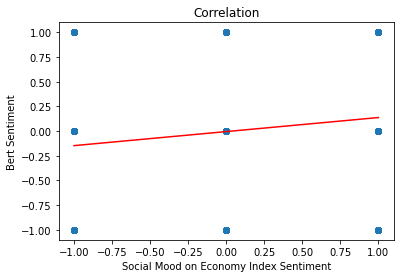

In [23]:
# adds the title
plt.title('Correlation')

x = smei_sentiment_data
y = bert_sentiment_data

# plot the data
plt.scatter(x, y)
  
# fits the best fitting line to the data
plt.plot(np.unique(x), 
         np.poly1d(np.polyfit(x, y, 1))
         (np.unique(x)), color='red')
  
# Labelling axes
plt.xlabel('Social Mood on Economy Index Sentiment')
plt.ylabel('Bert Sentiment')

plt.savefig('regression_curve.jpg')